In [1]:
#| default_exp ndwi_class

# NDWI 

In [2]:
#|hide
from nbdev.showdoc import *

In [3]:
#|export
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from flood_exercise import utils_func
from flood_exercise import const_vals as CONST

In [4]:
#|export

class ndwi():

  def __init__(self,
      path_to_imgs : str , # path to the folder that contains the images
      ):
     
     # get list of tif files
     self.list_of_files = utils_func.load_list_paths(path_to_imgs,filter_file = True)
     self.list_of_files = [x for x in self.list_of_files if 'Bolivia' in x]
     
     collector = {CONST.IMG_PATH_WATER_STR : [] , CONST.WATER_PERC_STR : []}
     # calculate NDWI and NDWI mask per image
     for path in self.list_of_files:
         self.ndwi_img ,self.mask , self.perc_water = self._ndwi_s2_(path)
         collector[CONST.IMG_PATH_WATER_STR].append(path)
         collector[CONST.WATER_PERC_STR].append(self.perc_water)

     self.water_perc = pd.DataFrame(collector)
           
  def _ndwi_s2_(self ,
                     path):
         
         with rasterio.open(path) as src:
            green = src.read(CONST.GREEN_BAND)
            nir = src.read(CONST.NIR_BAND)

            ndwi = (green - nir) / (green + nir)

            # Replace NaN values with 0
            ndwi = np.nan_to_num(ndwi, nan=-1)
            # generate mask 
            mask = np.where(ndwi<0 ,0 ,1)

            #calculate precentage of water pixel out of all the pixels in the image
            # count_water_pixels = np.sum(mask)
            # total_pixels = mask.shape[0]*mask.shape[1]
            perc_water = round((np.sum(mask) / (mask.shape[0]*mask.shape[1]))*100,2)
         return ndwi , mask ,perc_water
     




In [5]:
instance = ndwi(path_to_imgs = r"D:\git\flood_exercise\S2")
instance.water_perc

C:\Users\USER\AppData\Local\Temp\ipykernel_15656\3637247484.py:29: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)


,img_path,percentage_water
0,0.02,D:\git\flood_exercise\S2\Bolivia_76104_S2Hand.tif
1,14.19,D:\git\flood_exercise\S2\Bolivia_103757_S2Hand...
2,3.64,D:\git\flood_exercise\S2\Bolivia_60373_S2Hand.tif
3,33.57,D:\git\flood_exercise\S2\Bolivia_432776_S2Hand...
4,0.10,D:\git\flood_exercise\S2\Bolivia_360519_S2Hand...
5,66.69,D:\git\flood_exercise\S2\Bolivia_129334_S2Hand...
6,0.12,D:\git\flood_exercise\S2\Bolivia_233925_S2Hand...
7,39.74,D:\git\flood_exercise\S2\Bolivia_314919_S2Hand...
8,6.80,D:\git\flood_exercise\S2\Bolivia_294583_S2Hand...
9,2.76,D:\git\flood_exercise\S2\Bolivia_23014_S2Hand.tif


In [110]:
np.sum(instance.mask) / (instance.mask.shape[0]*instance.mask.shape[1])

0.03639984130859375

In [112]:
instance.mask.shape[0]*instance.mask.shape[1]

262144

In [89]:
instance.mask

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

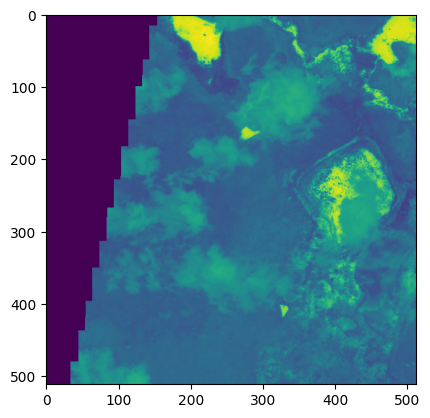

In [106]:
plt.imshow(instance.ndwi_img)

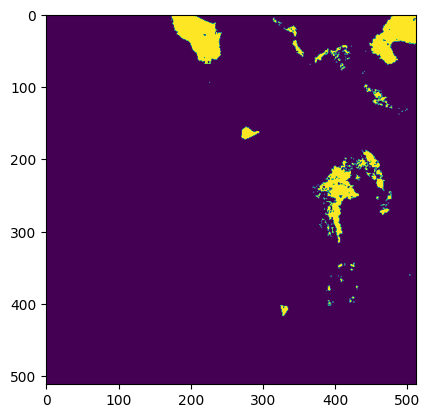

In [107]:
plt.imshow(instance.mask)

In [71]:
instance.mask

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])